# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import os
import pandas as pd
#import pandas_profiling

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool, cv

from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from lightgbm import LGBMRegressor
import lightgbm as lgb

In [2]:
#Задание констант

STATE = 12345

In [3]:
#чтение датасета
pth1 = 'autos.csv'
pth2 = '/datasets/autos.csv'

if os.path.exists(pth1):
    autos = pd.read_csv(pth1)
elif os.path.exists(pth2):
    autos = pd.read_csv(pth2)
else:
    print('Something is wrong, что-то пошло не так как надо')
    

In [4]:
autos.info(memory_usage='deep')

In [5]:
autos.sample(5)

In [6]:
autos.duplicated().sum()

In [7]:
#дубликатов немного, удалим их
autos = autos.drop_duplicates()

In [8]:
autos.duplicated().sum()

In [9]:
#дополнительная проверка на наличие пустых значений
autos.isna().sum()

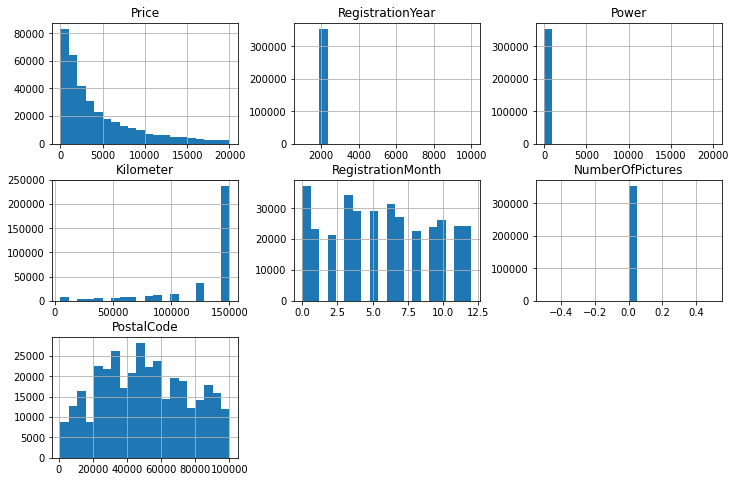

In [10]:
autos.hist(bins=20, figsize=(12, 8))
None

### Вывод

Входные данные содержат примерно 350 тыс. строк, 16 столбцов. 5 солбцов имеют пропущенные значения. Названия всех столбцов записаны с заглавной буквы и это можно исправить. Больше половины столбцов (9 шт) имеют тип данных object.

    0   DateCrawled        354369 non-null  object - норма, пропусков нет
    1   Price              354369 non-null  int64  - норма, пропусков нет
    2   VehicleType        316879 non-null  object - 37 490 пропусков (около 13%)
    3   RegistrationYear   354369 non-null  int64  - норма, пропусков нет
    4   Gearbox            334536 non-null  object - 19833 пропусков (около 6%)
    5   Power              354369 non-null  int64  - норма, пропусков нет
    6   Model              334664 non-null  object - 19705 пропусков (около 6%)
    7   Kilometer          354369 non-null  int64  - норма, пропусков нет
    8   RegistrationMonth  354369 non-null  int64  - норма, пропусков нет
    9   FuelType           321474 non-null  object - 32895 пропусков (около 9.3%)
    10  Brand              354369 non-null  object - норма, пропусков нет
    11  Repaired           283215 non-null  object - 71154 пропусков (около 20%)
    12  DateCreated        354369 non-null  object - норма, пропусков нет
    13  NumberOfPictures   354369 non-null  int64  - норма, пропусков нет
    14  PostalCode         354369 non-null  int64  - норма, пропусков нет
    15  LastSeen           354369 non-null  object - норма, пропусков нет

In [11]:
autos.columns

In [12]:
#переименование столбцов
autos.columns = ['date_crawled', 
                 'price', 
                 'vehicle_type', 
                 'registration_year', 
                 'gearbox',
                 'power', 
                 'model', 
                 'kilometer', 
                 'registration_month', 
                 'fuel_type', 
                 'brand',
                 'repaired', 
                 'date_created', 
                 'number_of_pictures', 
                 'postal_code',
                 'last_seen']

In [13]:
autos.columns

In [14]:

col_for_uniq =  [#'date_crawled', 
                 #'price', 
                 'vehicle_type', 
                 #'registration_year', 
                 'gearbox',
                 #'power', 
                 'model', 
                 #'kilometer', 
                 'registration_month', 
                 'fuel_type', 
                 'brand',
                 'repaired', 
                 #'date_created', 
                 'number_of_pictures', 
                 #'postal_code',
                 #'last_seen'
]

In [15]:
#просмотр уникальных значений в некоторых столбцах
for j in col_for_uniq:
    print(f'Столбец {j}')
    print(autos[j].unique())
    print('-------------------------------------')

Все эти столбцы достаточно нормальные, кроме `number_of_pictures`. В нём все значения нулевые. Такой столбец точно нужно удалить.

Кроме того, можно удалить и другие столбцы, содержащие информацию которая на цену (целевой признак) не повлияет.

In [16]:
autos.number_of_pictures.max()

In [17]:
#список столбцов для удаления
col_del = ['date_crawled', 
                 #'price', 
                 #'vehicle_type', 
                 #'registration_year', 
                 #'gearbox',
                 #'power', 
                 #'model', 
                 #'kilometer', 
                 #'registration_month', 
                 #'fuel_type', 
                 #'brand',
                 #'repaired', 
                 'date_created', 
                 'number_of_pictures', 
                 'postal_code',
                 'last_seen'
]

In [18]:
autos = autos.drop(col_del, axis=1)

In [19]:
autos.info()

In [20]:
#EDA с помощью pandas_profiling
#pandas_profiling.ProfileReport(autos)

## Подготовка данных

### Удаление дубликатов строк

In [21]:
autos.duplicated().sum()

In [22]:
#дубликатов не мало, около 6,1%, удалим их
autos = autos.drop_duplicates()

In [23]:
autos.duplicated().sum()

### Заполнение пропусков и устранение аномальных значений

In [24]:
#Функция для исследования одного столбца
def issue(col_name):
    
    print(' ___________________')
    print('|------DESCRIBE-----|')
    print(autos[col_name].describe())
    
    #количество пропусков в процентах от всего датасета
    print()
    print(' ___________________')
    print('|------ПРОПУСКИ %-----|')
    print(100 * autos[col_name].isna().sum() / len(autos))
    
    #просмотр уникальных значений
    print()
    print(' ______________________________')
    print('|------УНИКАЛЬНЫЕ ЗНАЧЕНИЯ-----|')
    print(autos[col_name].unique())
    
    #распределение уникальных значений в долях
    print()
    print(' ________________________')
    print('|------ДОЛИ ЗНАЧЕНИЙ-----|')
    print(autos[col_name].value_counts(normalize=True))
    
    #гистограмма значений в столбце
    print()
    print(' ______________________')
    print('|------ГИСТОГРАММА-----|')
    autos[col_name].hist(bins=20)

In [25]:
autos.columns

##### столбец price

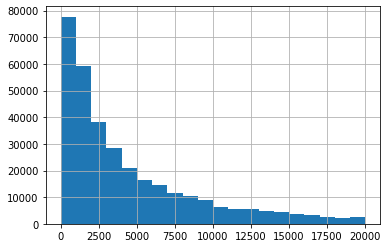

In [26]:
#столбец price
issue('price')

есть автомобили с нереально низкой ценой, это необходимо исправить

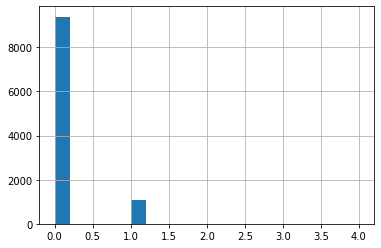

In [27]:
autos.query('price < 5').price.hist(bins=20)

In [28]:
autos.query('price < 5').price.count()/len(autos)

авто с низкой ценой 3,2%, можно такие строки удалить, но я решил заменить их на медиану

In [29]:
autos.loc[autos['price'] < 5, 'price'] = autos['price'].median()

In [30]:
autos['price'].describe()

##### столбец vehicle_type

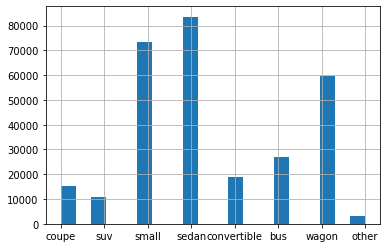

In [31]:
#столбец vehicle_type
issue('vehicle_type')

Тип кузова sedan самый распространённый, заполню пропуски им, хоть это и не совсем правильно.

In [32]:
autos.vehicle_type = autos.vehicle_type.fillna('sedan')

In [33]:
#проверка
autos['vehicle_type'].unique()

##### столбец registration_year

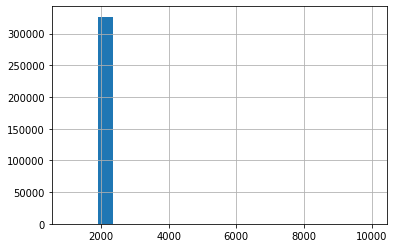

In [34]:
issue('registration_year')

In [35]:
autos.query('registration_year < 1950').registration_year.count()

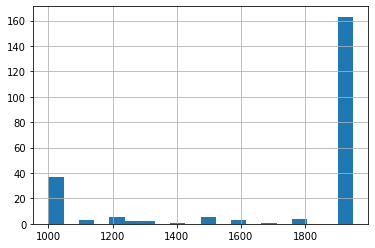

In [36]:
autos.query('registration_year < 1950').registration_year.hist(bins=20)

In [37]:
autos.query('registration_year < 1950').price.max()

автомобили таких годов это антиквариат и адекватно оценить и стоимость сложно.

Думаю что авто с годами ниже чем 1950 лучше удалить.

In [38]:
autos = autos.query('registration_year > 1950')

In [39]:
autos.registration_year.describe()

In [40]:
autos.query('registration_year > 2019').registration_year.count()

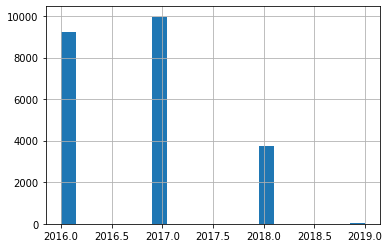

In [41]:
autos.query('2060 > registration_year > 2015').registration_year.hist(bins=20)

также удалю все записи где год регистрации больше чем 2019

In [42]:
autos = autos.query('registration_year <= 2019')

In [43]:
autos.registration_year.describe()

##### столбец gearbox

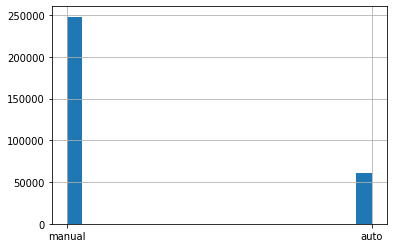

In [44]:
issue('gearbox')

механическая коробка намного распространённее чем автоматическая, заменю на неё

In [45]:
autos.gearbox = autos.gearbox.fillna('manual')

In [46]:
#проверка
autos['gearbox'].unique()

##### столбец power

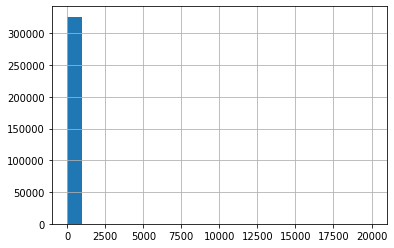

In [47]:
issue('power')

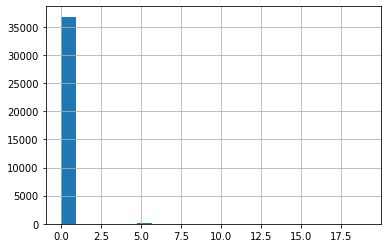

In [48]:
autos.query('power < 20').power.hist(bins=20)

больше 35 тысяч авто с нулевой мощностью мотора, это слишком много чтобы удалять такие данные.

Заменю на медиану

In [49]:
autos.loc[autos['power'] < 2, 'power'] = autos['power'].median()

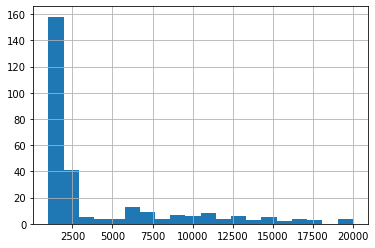

In [50]:
autos.query('power > 1000').power.hist(bins=20)

In [51]:
autos.query('power > 1000').power.count()

машин с двигателем более 1000 лс всего 290 шт, удалю их.

In [52]:
autos = autos.query('power <= 1000')

In [53]:
autos.power.describe()

##### столбец model

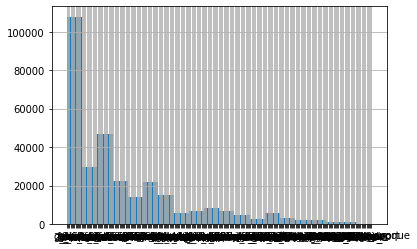

In [54]:
issue('model')

Пропусков в названии модели около 5,6% , можно или удалить вообще такие машины, или заменить на "other".

Принимаю решение заменить на "other", т.к. такая категория уже есть.

In [55]:
autos.model = autos.model.fillna('other')

In [56]:
autos.model.isna().sum()

##### столбец kilometer

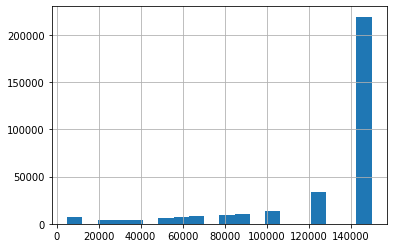

In [57]:
issue('kilometer')

не видно неадекватных  значений. Принимаю решение не трогать этот столбец.

##### столбец registration_month

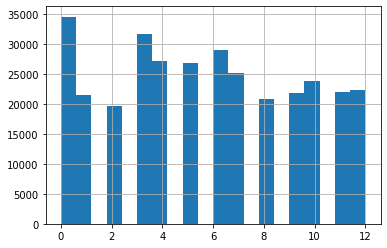

In [58]:
issue('registration_month')

аномальное значение это нулевой месяц

In [59]:
autos.query('registration_month == 0').registration_month.count()

In [60]:
autos.query('registration_month == 12').registration_month.count()

в таблице корреляции есть небольшая связь, около 0.155, между месяцем выпуска авто и его ценой.

Достоверно понять к какому месяцу/месяцам относится нулевой месяц невозможно.

Можно заполнить эти значения или случайными числами или удалить такие строки. Таких строк примерно 10,6%.

Принимаю решение заменить нулевые числа на случайные в диапазоне 1..12

In [61]:
autos['registration_month'] = autos['registration_month'] \
.apply(lambda x: np.random.randint(1,13) if x == 0 else x)

In [62]:
sorted(autos['registration_month'].unique())

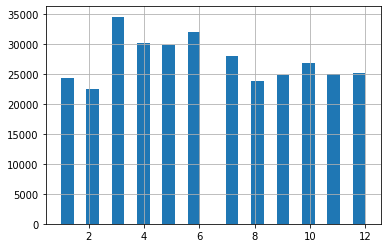

In [63]:
autos['registration_month'].hist(bins=24)

##### столбец fuel_type

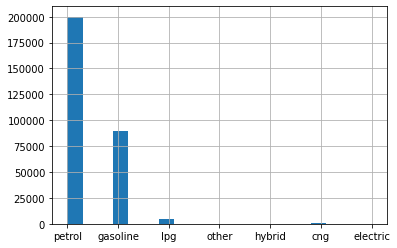

In [64]:
issue('fuel_type')

в большинстве машины на бензине, пропуски заменю на бензин.

In [65]:
autos.fuel_type = autos.fuel_type.fillna('petrol')

In [66]:
autos.fuel_type.unique()

##### столбец brand

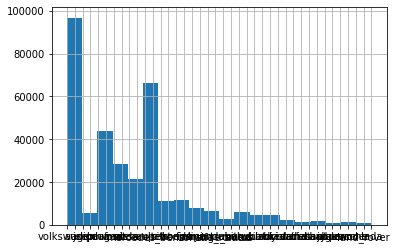

In [67]:
issue('brand')

в этом столбце все в порядке.

##### столбец repaired

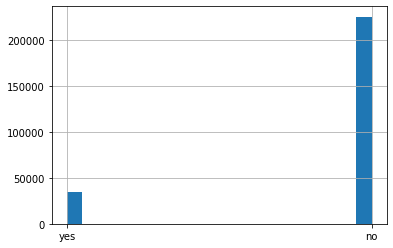

In [68]:
issue('repaired')

Пропусков много и удалять такой столбец это потерять 1/5 часть данных. 

Замена пропусков на 'no'

In [69]:
autos.repaired = autos.repaired.fillna('no')

In [70]:
autos.repaired.unique()

## Обучение моделей

### Модель CATBoost (grid_search)

так как CATBoost кодирует категориальные признаки сама, то просто разделю выборку на обучающую и тестовую

In [71]:
features_train, features_test, target_train, target_test = \
train_test_split(autos.drop('price', axis=1), 
                 autos.price, 
                 test_size=0.2, 
                 random_state=STATE)

In [72]:
features_train.shape

In [73]:
features_test.shape

In [74]:
target_train.shape

In [75]:
target_test.shape

In [76]:
features_train.sample(3)

In [77]:
features_train.info()

In [78]:
#список категориальных столбцов
cat_features = ['vehicle_type', 'gearbox', 'model',
                'fuel_type', 'brand', 'repaired']

In [79]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 10]}

In [80]:
model_cb = CatBoostRegressor(iterations=200,
                          loss_function="RMSE",
                          cat_features=cat_features,
                          verbose=20)

In [81]:
%%time
grid_search_result = model_cb.grid_search(grid,
                                       X=features_train, 
                                       y=target_train,
                                       cv=5,                  
                                       shuffle=True,
                                       plot=True
                                      )

In [82]:
#табличка с результатами grid_search
cv_results_catboost = pd.DataFrame(grid_search_result)

In [83]:
cv_results_catboost

In [84]:
a = list(cv_results_catboost.cv_results[3:4])

In [85]:
min(a[0])

Минимальное значение RMSE=1735, достигнуто на depth=10.0, learning_rate=0.1

### Преобразование категориальных столбцов  OrdinalEncoder

и разделение на обучающую, валидационую и тестовую выборки

In [86]:
#делаем копию всех выборок
features_train_oe = features_train.copy()
features_test_oe = features_test.copy()
target_train_oe = target_train.copy()
target_test_oe = target_test.copy()



In [87]:
#создание обьекта OrdinalEncoder
#если на трансформации попадётся неизвестное значение, его закодирует числом 1000
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1000)

In [88]:
#обучаем энкодер на обучающей выборке, столбцы только категориальные
oe.fit(features_train_oe[cat_features])

In [89]:
#трансформируем обучающую выборку
features_train_oe[cat_features] = oe.transform(features_train_oe[cat_features])

In [90]:
#трансформируем тестовую выборку
features_test_oe[cat_features] = oe.transform(features_test_oe[cat_features])

In [91]:
features_train_oe.sample(5)

In [92]:
features_train_oe.info(memory_usage='deep')

In [93]:
features_test_oe.info(memory_usage='deep')

Количество столбцов не изменилось, но при этом обьем занимаемой памяти упал с 217Мб до 30Мб

In [94]:
#отделяем от features_train_oe данные для валидации
features_train_oe, features_val_oe, target_train_oe, target_val_oe \
= train_test_split(features_train_oe, 
                   target_train_oe, 
                   test_size=0.25, 
                   random_state=STATE)

In [95]:
features_train_oe.shape

In [96]:
features_val_oe.shape

In [97]:
features_test_oe.shape

In [98]:
target_train_oe.shape

In [99]:
target_val_oe.shape

In [100]:
target_test_oe.shape

### Преобразование категориальных столбцов OHE

In [101]:
#преобразование категориальных столбцов техникой OHE
autos_ohe = pd.get_dummies(autos, columns=cat_features, drop_first=True)

In [102]:
autos_ohe.sample(5)

In [103]:
x_ohe, features_test_ohe, y_ohe, target_test_ohe \
= train_test_split(autos_ohe.drop('price', axis=1), 
                   autos_ohe.price, 
                   test_size=0.2, 
                   random_state=STATE)

In [104]:
features_train_ohe, features_val_ohe, target_train_ohe, target_val_ohe \
= train_test_split(x_ohe, 
                   y_ohe, 
                   test_size=0.25, 
                   random_state=STATE)

### Модель LightGBM 

In [105]:
lgb.__version__

#### Обучение LightGBM и проверка на данных кодированных OrdinalEncoder

In [106]:
#модель для данных кодированных OrdinalEncoder
model_lgbmr_oe = LGBMRegressor(
    max_depth = 12,
    learning_rate = 0.1,
    
    num_iterations = 200
)

In [107]:
%%time
model_lgbmr_oe.fit(features_train_oe,target_train_oe)

In [108]:
%%time
lgbmr_predict = model_lgbmr_oe.predict(features_val_oe)

In [109]:
mse = mean_squared_error(target_val_oe, lgbmr_predict)
mse**0.5

In [110]:
r2_score(target_val_oe, lgbmr_predict)

#### Обучение LightGBM и проверка на данных кодированных OHE

In [111]:
#модель для данных кодированных OneHotEncoder
model_lgbmr_ohe = LGBMRegressor(
    max_depth = 12,
    learning_rate = 0.1,
    
    num_iterations = 200
)

In [112]:
%%time
model_lgbmr_ohe.fit(features_train_ohe, target_train_ohe)

In [113]:
%%time
lgbmr_predict = model_lgbmr_ohe.predict(features_val_ohe)

In [114]:
mse = mean_squared_error(target_val_ohe, lgbmr_predict)
mse**0.5

In [115]:
r2_score(target_val_ohe, lgbmr_predict)

### Модель LinearRegression

In [116]:
lr = LinearRegression()

In [117]:
%%time
lr.fit(features_train_ohe, target_train_ohe)

In [118]:
%%time
pred_lr = lr.predict(features_val_ohe)

время обучения примерно 32.3 s

время предсказания 333 ms


In [119]:
mse = mean_squared_error(target_val_ohe, pred_lr)
mse**0.5

In [120]:
r2_score(target_val_ohe, pred_lr)

### Модель Дерево

In [121]:
#логарифмическая сетка параметров для модели Дерево
params = {
    'max_depth':[16,32], 
    'min_samples_split':[2,4], 
    'min_samples_leaf':[6,8]
}

In [122]:
TreeReg = DecisionTreeRegressor(random_state=STATE)

In [123]:
clf = GridSearchCV(TreeReg, params, scoring='r2', cv=5, n_jobs=-1)

In [124]:
%%time
clf.fit(features_train_ohe, target_train_ohe)

In [125]:
clf.best_score_

In [126]:
clf.best_params_

Используем полученные параметры в GridSearchCV для тренировки модели Дерево

In [127]:
TreeReg = DecisionTreeRegressor(max_depth=16, 
                               min_samples_leaf=8, 
                                min_samples_split=2, 
                                random_state=STATE)

In [128]:
%%time
TreeReg.fit(features_train_ohe, target_train_ohe)

In [129]:
%%time
pred_TreeReg = TreeReg.predict(features_val_ohe)

время обучения примерно 7.4 s

время предсказания 131 ms


In [130]:
pred_TreeReg

In [131]:
mse = mean_squared_error(target_val_ohe, pred_TreeReg)
mse**0.5

In [132]:
r2_score(target_val_ohe, pred_TreeReg)

## Анализ моделей

Рассмотренные модели показали следующие результаты на валидационных данных

Модель                                 |время обучения|время предсказания|RMSE  |   R2  |
---------------------------------------|--------------|------------------|------|-------|
CATBoost                               |1min 44s      |                  | 1735 |       |
LightGBM (данные OrdinalEncoder)       |26.6 s        | 896 ms           | 1764 | 0.843 |
LightGBM (данные OHE)                  |5.65 s        | 1.08 s           | 1759 | 0.844 |
LinearRegression (данные OHE)          |32.3 s        | 333 ms           | 2797 | 0.604 |
DecisionTreeRegressor, (данные OHE)    |5.17 s        | 135 ms           | 1939 | 0.810 |

Лучшим качеством по метрике RMSE обладает модель CATBoost.

Поэтому для проверки на тестовой выборке выберу её.

In [133]:
#функция для тестирования моделей
def test_model(name_model, features, target):
    pred = name_model.predict(features)
    print('RMSE =', (mean_squared_error(target, pred))**0.5)
    print('R2 =', r2_score(target, pred))

##### модель CatBoost

In [134]:
test_model(model_cb, features_test, target_test)

## Выводы

Рассмотрены всего 4 вида моделей с разными видами данных:

 - CATBoost
 - LightGBM (данные OrdinalEncoder)
 - LightGBM (данные OHE)
 - LinearRegression (данные OHE)
 - DecisionTreeRegressor, одно дерево, (данные OHE)
 
 
Данные о работе моделей на валидационной выборке сведены в таблицу
 
Модель                                 |время обучения|время предсказания|RMSE  |   R2  |
---------------------------------------|--------------|------------------|------|-------|
CATBoost                               |1min 44s      |                  | 1735 |       |
LightGBM (данные OrdinalEncoder)       |26.6 s        | 896 ms           | 1764 | 0.843 |
LightGBM (данные OHE)                  |5.65 s        | 1.08 s           | 1759 | 0.844 |
LinearRegression (данные OHE)          |32.3 s        | 333 ms           | 2797 | 0.604 |
DecisionTreeRegressor, (данные OHE)    |5.17 s        | 135 ms           | 1939 | 0.810 |

-- -- 

Самое лучшее качество предсказаний имеет CATBoost, эта модель имеет наивысшие показатели среди других.

CATBoost на тестовой выборке так же показала весьма неплохие результаты **RMSE = 1741**, практические совпадающие с валидационными **RMSE = 1735**

LightGBM (на разных данных) имеет также низкие значение RMSE, сравнимые с CATBoost.

Линейная регрессия показала плохие результаты.

Модель дерево, довольно быстро обучается, и предсказывает быстрее любой другой модели, всего за 135ms.
При этом имеет не плохие показатели.
